In [1]:
suppressPackageStartupMessages({
  library(cowplot)
  library(dataorganizer)
  library(EBImage)
  library(ggplot2)
  library(magrittr)
  library(Matrix)
  library(readr)
  library(cellAdmix)
})
devtools::load_all()

theme_set(theme_bw())

ℹ Loading cellAdmixNotebooks


In [2]:
MIN_MOLS_PER_CELL <- 10

## Load data

In [3]:
df_raw <- DatasetPath('mouse_gut', 'segmentation', 'segmentation.csv') %>%
    read_csv(show_col_types=FALSE)

Original (Baysor)

In [4]:
so <- DatasetPath('mouse_gut', 'clustering', 'so.rds') %>% read_rds()
dim(so)

[1]  240 7416

SCS:

In [5]:
scs_spot_labels <- DatasetPath('mouse_gut', 'seg_method_results', 'scs', 'results', 'spot2cell_0:0:0:0.txt') %>%
    read_delim(show_col_types=FALSE, col_names=c('spot', 'cell')) %$%
    setNames(as.integer(cell), spot)

scs_cellpose_spot_labels <- DatasetPath('mouse_gut', 'seg_method_results', 'scs_cellpose', 'results', 'spot2cell_0:0:0:0.txt') %>%
    read_delim(show_col_types=FALSE, col_names=c('spot', 'cell')) %$%
    setNames(as.integer(cell), spot)

In [6]:
scs_df <- DatasetPath('mouse_gut', 'seg_method_results', 'scs', 'input', 'df.csv') %>%
    read_csv(show_col_types=FALSE) %>% mutate(
        spot=paste0(column, ':', row),
        cell=scs_spot_labels[spot] %>% ifelse(is.na(.), 0, .),
        cell_cellpose=scs_cellpose_spot_labels[spot] %>% ifelse(is.na(.), 0, .)
    )

scs_df_cellpose <- scs_df %>% mutate(cell=cell_cellpose)

New names:
• `` -> `...1`


BIDCell

In [7]:
bidcell_labels <- DatasetPath(
    'mouse_gut', 'seg_method_results', 'bidcell', 'output', 'model_outputs',
    '2024_11_12_06_37_26', 'test_output', 'cells_resized.tif'
) %>% readImage(as.is=TRUE) %>% imageData()

In [8]:
bidcell_df <- DatasetPath('mouse_gut', 'seg_method_results', 'bidcell', 'input', 'molecules.csv') %>%
    read_csv(show_col_types=FALSE) %>%
    mutate(x_pixel=(x_pixel+1), y_pixel=(y_pixel+1))

In [9]:
bidcell_scale <- max(bidcell_df$y_pixel) / (ncol(bidcell_labels) - 1)

bidcell_df$cell <- bidcell_df[,c('y_pixel', 'x_pixel')] %>% as.matrix() %>% bidcell_labels[.]

ProSeg

In [10]:
proseg_df <- DatasetPath('mouse_gut', 'seg_method_results', 'proseg', 'transcript-metadata.csv') %>%
    read_csv(show_col_types=FALSE) %>%
    mutate(cell=ifelse(assignment == 4294967295, 0, assignment + 1))

ComSeg

In [11]:
comseg_df <- DatasetPath('mouse_gut', 'comseg_format', 'results', '11_d6_h5_min20_s7_r1413', 'segmentation.csv') %>%
    read_csv(show_col_types=FALSE) %>% rename(cell=cell_index_pred)

New names:
• `` -> `...1`


In [ ]:
comseg_df$cell %>% unique() %>% length()

[1] 6584

ClusterMap

In [13]:
clustermap_df <- DatasetPath('mouse_gut', 'seg_method_results', 'clustermap', 'spots_all.csv') %>%
    read_csv(show_col_types=FALSE) %>% mutate(cell=(clustermap + 1), gene=gene_name)

## Prepare data

In [14]:
dfs <- list(
    SCS=scs_df,
    SCSCellPose=scs_df_cellpose,
    BIDCell=bidcell_df,
    ProSeg=proseg_df,
    ComSeg=comseg_df,
    ClusterMap=clustermap_df
)

In [15]:
cms <- lapply(dfs, \(df) {
    df %$% table(gene, cell) %>% unclass() %>% as('dgCMatrix')
})
cms$Baysor <- so[['RNA']]$counts

cms %<>% lapply(\(cm) cm[, (colSums(cm) >= MIN_MOLS_PER_CELL) & (colnames(cm) != '0')])

In [16]:
for (n in names(cms)) {
    colnames(cms[[n]]) %<>% {paste0(n, '_', .)}
}

In [17]:
palette <- c(
    Baysor='#F8766D', SCS='#00C19F', SCSCellPose='#93AA00', BIDCell='#00BA38',
    ProSeg='#D39200', ComSeg='#00B9E3', ClusterMap='#619CFF',
    scRNAseq='#888888'
)

plot_theme <- theme(axis.text.x=element_text(angle=45, hjust=1))

## Basic parameters

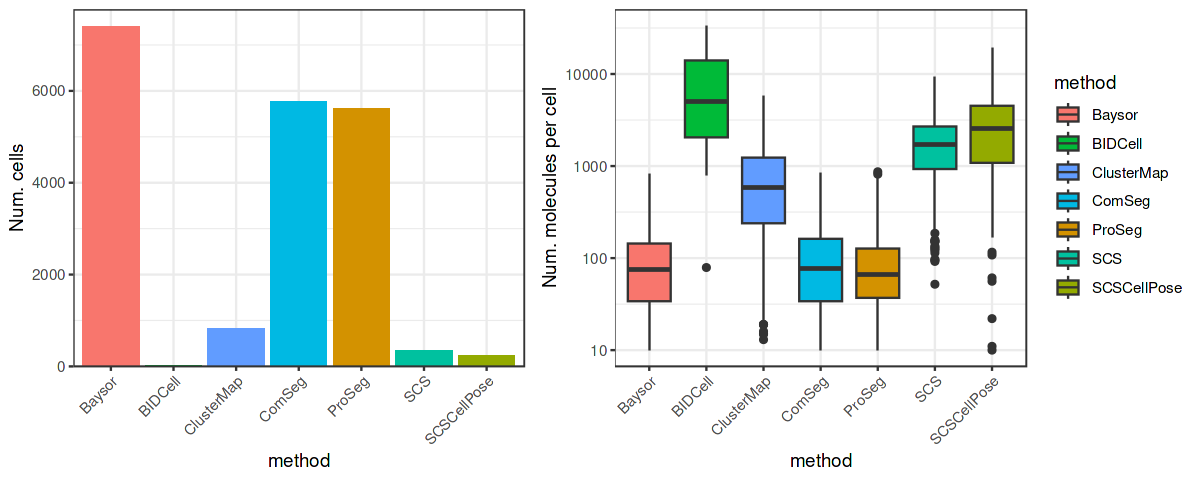

In [18]:
options(repr.plot.width=10, repr.plot.height=4)

n_cells <- sapply(cms, ncol) %>% data.frame(method=names(.), n_cells=.)

n_mols_per_cell <- names(cms) %>%
    lapply(\(n) data.frame(method=n, n_mols=colSums(cms[[n]]))) %>%
    bind_rows()

gg1 <- ggplot(n_cells) +
    geom_col(aes(x=method, y=n_cells, fill=method)) +
    ylab('Num. cells') +
    scale_y_continuous(expand=c(0, 0, 0.05, 0)) +
    theme(legend.position="none") +
    scale_fill_manual(values=palette) +
    plot_theme

gg2 <- ggplot(n_mols_per_cell) +
    geom_boxplot(aes(x=method, y=n_mols, fill=method)) +
    scale_y_log10(n.breaks=6) +
    ylab('Num. molecules per cell') +
    scale_fill_manual(values=palette) +
    plot_theme

plot_grid(gg1, gg2, rel_widths=c(0.8, 1))

In [19]:
valid_methods <- c('Baysor', 'ComSeg', 'ProSeg')

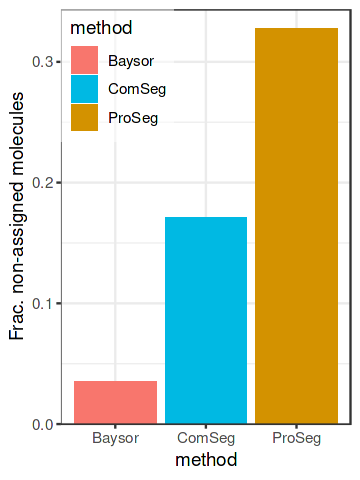

In [ ]:
options(repr.plot.width=3, repr.plot.height=4)

noise_fracs <- sapply(cms, sum) %>% {1 - . / nrow(df_raw)} %>%
    .[valid_methods] %>% {data.frame(method=names(.), frac=.)}

ggplot(noise_fracs) +
    geom_col(aes(x=method, y=frac, fill=method)) +
    ylab('Frac. non-assigned molecules') +
    scale_y_continuous(expand=c(0, 0, 0.05, 0)) +
    theme_legend(position=c(0, 1)) +
    scale_fill_manual(values=palette)

## Annotation transfer

In [21]:
shared_genes <- sapply(cms[valid_methods], rownames) %>% Reduce(intersect, .)

In [22]:
so_joint <- cms[valid_methods] %>%
  lapply(`[`, shared_genes,) %>% Reduce(cbind, .) %>%
  CreateSeuratObject() %>% process_seurat()

Normalizing layer: counts



Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  Nlrp6, Clca3b, Slc5a1, Fzd5, Slc51a, Maoa, Cps1, Apob, Sdc1, Krt7 
	   Itgam, Klk1, Ffar4, Mki67, Stmn1, Net1, Ltb4r2, Slc18a1, Cd14, Hrh1 
	   Marcksl1, Htr2c, Tm4sf4, Htr4, Hmgb2, Lpar5, Ptger4, Chrm4, Chrm1, Ptgdr2 
Negative:  Vim, Cd4, C1qb, C1qc, Cd44, Thy1, Scarb1, Cspg4, Cd3e, Mzb1 
	   Jaml, Nes, Cd79a, Cd79b, Cd34, Adgrf5, S1pr3, S1pr1, Itgae, Il7r 
	   Nt5e, Tigit, Acta2, Nkg7, Icos, Glp2r, Cd3d, Adrb2, Lrmp, Fzd4 
PC_ 2 
Positive:  Slc51a, Apob, Acta2, Chrm2, Adgrd1, Galr2, Ptger3, Htr2c, Lpar3, Slc5a1 
	   Chrm4, Ada, Ltb4r2, Plb1, Nt5e, Ptgfr, Adra2b, Hrh1, Maoa, Rgs4 
	   Slc2a2, Taar8c, Cspg4, Ifng, Adrb1, Fzd2, Scn3a, Adrb3, Tymp, Ffar3 
Negative:  Stmn1, Mki67, Slc12a2, Txndc5, Cps1, Hmgb2, Kit, Adra2a, Sox4, Clca3b 
	   Lgr5, Krt7, Cd44, Htr4, Cd14, Mptx2, Ffar2, Chrm1, Tm4sf4, Itgam 
	   Ffar4, Marcksl1, Tspan13, Klk1, Ptgdr2, Ccnl2, Slc18a1, Jaml, Gpr55, Fzd9 
PC_ 3 
Pos

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 18799
Number of edges: 740312

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.8031
Number of communities: 34
Elapsed time: 2 seconds


In [23]:
so_joint$sample <- strsplit(colnames(so_joint), '_') %>% sapply(`[[`, 1)

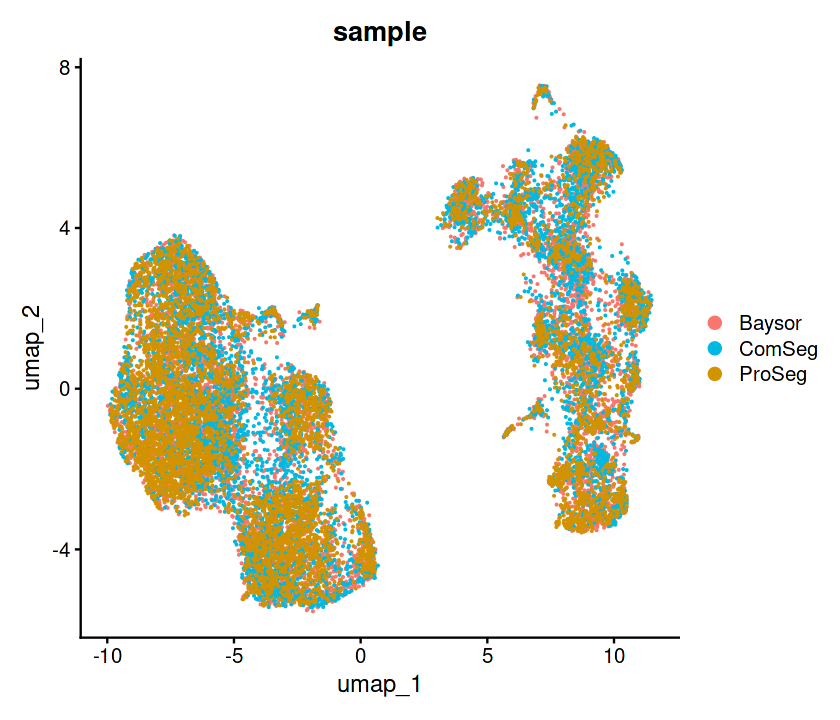

In [24]:
options(repr.plot.width=7, repr.plot.height=6)
UMAPPlot(so_joint, group.by='sample') +
    scale_color_manual(values=palette)

In [25]:
so_joint$cell_type <- NA
so_joint$cell_type[paste0('Baysor_', colnames(so))] <- adjust_gut_cell_types(so$cell_type)

cell_types <- Embeddings(so_joint, 'pca') %>%
  transfer_annotation_knn(so_joint$cell_type, ref.prefix='Baysor_')

so_joint$cell_type[names(cell_types)] <- cell_types

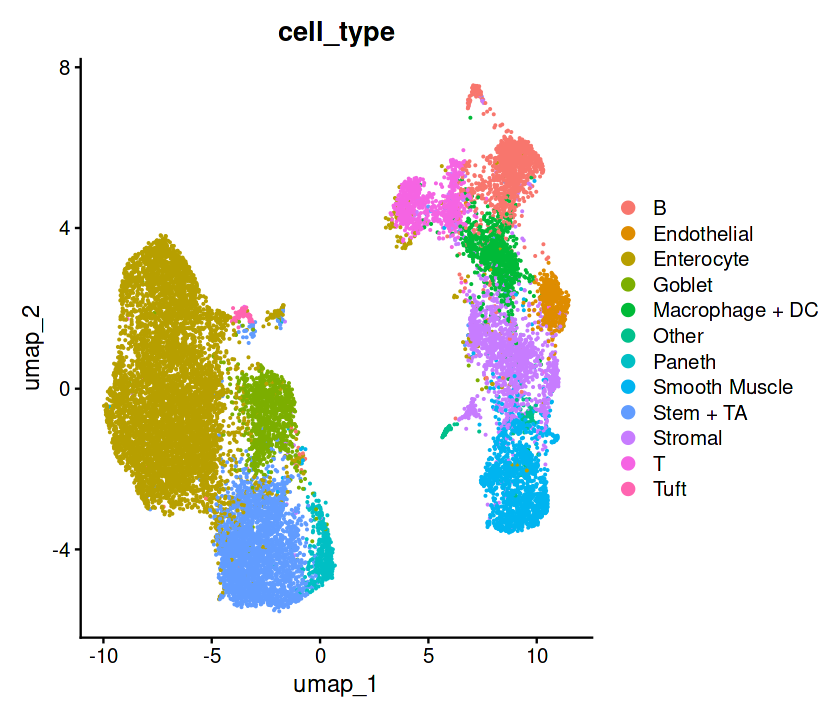

In [26]:
options(repr.plot.width=7, repr.plot.height=6)
UMAPPlot(so_joint, group.by='cell_type')

In [ ]:
so_joint$cell_type %>%
  {tibble(cell=names(.), cell_type=.)} %>%
  mutate(protocol=sapply(strsplit(cell, '_'), `[[`, 1)) %>%
  write_csv(CachePath('gut_cell_types_transferred.csv'))

## Admixture scoring

In [33]:
so_rna <- prepare_gut_scrna()
so_rna

An object of class Seurat 
27998 features across 3180 samples within 1 assay 
Active assay: RNA (27998 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

In [34]:
sos <- so_joint %>% SplitObject(split.by='sample')
sos$scRNAseq <- so_rna

Missing cell types:

In [35]:
common_cell_types <- lapply(sos, \(so) unique(so$cell_type)) %>%
    Reduce(intersect, .) %>% setdiff('Other')
lapply(sos, \(so) setdiff(unique(so$cell_type), common_cell_types))

$Baysor
[1] "Stromal"         "Smooth Muscle"   "Other"           "Endothelial"    
[5] "Macrophage + DC" "T"               "B"              

$ComSeg
[1] "Smooth Muscle"   "Other"           "Stromal"         "B"              
[5] "Endothelial"     "T"               "Macrophage + DC"

$ProSeg
[1] "Smooth Muscle"   "Other"           "Stromal"         "Endothelial"    
[5] "Macrophage + DC" "B"               "T"              

$scRNAseq
character(0)

In [36]:
sos %<>% lapply(\(so) subset(so, cells=colnames(so)[so$cell_type %in% unique(common_cell_types)]))

### Molecules

### Estimate adjacency

In [37]:
df_spatial <- df_raw %>% mutate(cell=paste0('Baysor_C', cell)) %>%
    filter(cell %in% colnames(sos$Baysor)) %>%
    mutate(cell_type=sos$Baysor$cell_type[cell])

In [38]:
cell_adj_df <- estimate_cell_adjacency(df_spatial, random.shift=1e-2, n.cores=70)
cell_type_adj_mat <- estimate_cell_type_adjacency(cell_adj_df)
cell_type_adj_mat

,Enterocyte,Goblet,Paneth,Stem + TA,Tuft
Enterocyte,5.708382,5.062500,1.000000,2.394495,6.636364
Goblet,1.442136,1.568465,1.250000,1.468165,1.500000
Paneth,2.000000,1.250000,2.868966,2.207373,1.000000
Stem + TA,2.039062,4.900000,3.214765,5.124528,6.000000
Tuft,1.258621,1.500000,1.000000,1.263158,1.076923


## Estimate admixture scores

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


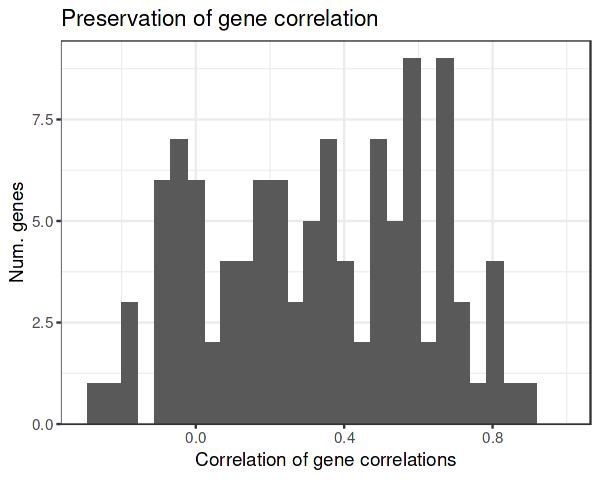

In [39]:
options(repr.plot.width=5, repr.plot.height=4)

cor_cors <- estimate_correlation_preservation(sos$Baysor[['RNA']]$data, sos$scRNAseq[['RNA']]$data)
plot_correlation_preservation(cor_cors)

In [40]:
exclude_genes <- list(
  all=c('Ada', 'Tnfrsf21', 'Marcksl1'),
  Goblet=c('Cps1', 'Maoa', 'Clca3b', 'H2-Eb1'),
  Paneth=c('Hmgb2', 'H2-Eb1')
)

In [41]:
cont_infos <- lapply(sos, \(so) {
  estimate_contamination_scores_seurat(
      sos$scRNAseq, so, cell.type.adj.mat=cell_type_adj_mat,
      p.c=0.25, signal.thres=0.25, min.expr.frac=0.05,
      exclude.genes=exclude_genes, adjust=TRUE
  )
})

Warning message in estimate_contamination_scores(cm.rna = so.rna[["RNA"]]$counts, :
“Some genes not found in both cm.rna and cm.spatial, 235 genes left”
Warning message in FUN(X[[i]], ...):
“Genes with high expression in Tuft detected in contamination: 'Cps1', 'Clca3b', 'H2-Eb1', 'Slc12a2', 'Neat1'. Perhaps you should improve the annotation or mask these genes out (`exclude.genes`).”
Warning message in estimate_contamination_scores(cm.rna = so.rna[["RNA"]]$counts, :
“Some genes not found in both cm.rna and cm.spatial, 235 genes left”
Warning message in FUN(X[[i]], ...):
“Genes with high expression in Tuft detected in contamination: 'Cps1', 'Clca3b', 'H2-Eb1', 'Slc12a2', 'Neat1'. Perhaps you should improve the annotation or mask these genes out (`exclude.genes`).”
Warning message in estimate_contamination_scores(cm.rna = so.rna[["RNA"]]$counts, :
“Some genes not found in both cm.rna and cm.spatial, 235 genes left”


Warning message in FUN(X[[i]], ...):
“Genes with high expression in Tuft detected in contamination: 'Cps1', 'Clca3b', 'H2-Eb1', 'Slc12a2', 'Neat1'. Perhaps you should improve the annotation or mask these genes out (`exclude.genes`).”
Warning message in FUN(X[[i]], ...):
“Genes with high expression in Goblet detected in contamination: 'Mrpl15', 'Pdcl3', 'Mrps9', 'Hspd1', 'Tm4sf20', 'Prdx6', 'Aldh9a1', 'Tstd1', 'Marc2', 'Agpat2', 'Mtx2', 'Id1', 'Top1', 'Pkig', 'Sdc4', 'Zfos1', 'Glod5', 'Otc', 'Bex1', 'Pdha1', 'Hadh', 'Gipc2', 'Decr1', 'Ccdc107', 'Aldob', 'Elovl1', 'Sfn', 'Akr7a5', 'Efhd2', 'Fam213b', 'Fgfbp1', 'Qdpr', 'Lap3', 'Aldh2', 'Rfc2', 'Cdx2', 'Capza2', 'Mgam', 'Gng12', 'Krcc1', 'Immt', 'Mgst1', 'Tmc4', 'Tsen34', 'Psmc4', 'Fam98c', '2200002D01Rik', 'Myh14', 'Aamdc', 'Arl6ip1', 'Sephs2', 'Prap1', 'Echs1', 'Ifitm3', 'Cd81', 'Ifngr1', 'Psap', 'Tspan15', 'Plpp2', 'Misp', 'Gpx4', 'Gna11', 'Socs2', 'Ccl25', 'Lamp1', 'Vdac3', 'Gsr', 'Kxd1', 'Tradd', 'Irf8', 'Cyba', 'Aprt', 'Thoc7', 'Lgal

### Distributions

In [42]:
admix_score_df <- names(cont_infos) %>% lapply(\(tn) {
    cont_infos[[tn]]$doublet.scores %>%
        {data.frame(scores=., cell_type=sos[[tn]]$cell_type[names(.)], cell=names(.), dataset=tn)}
}) %>% bind_rows() %>% mutate(scores=pmin(scores, 0.3))

Notch went outside hinges
ℹ Do you want `notch = FALSE`?
Notch went outside hinges
ℹ Do you want `notch = FALSE`?
Notch went outside hinges
ℹ Do you want `notch = FALSE`?
Notch went outside hinges
ℹ Do you want `notch = FALSE`?
Notch went outside hinges
ℹ Do you want `notch = FALSE`?
Notch went outside hinges
ℹ Do you want `notch = FALSE`?
Notch went outside hinges
ℹ Do you want `notch = FALSE`?


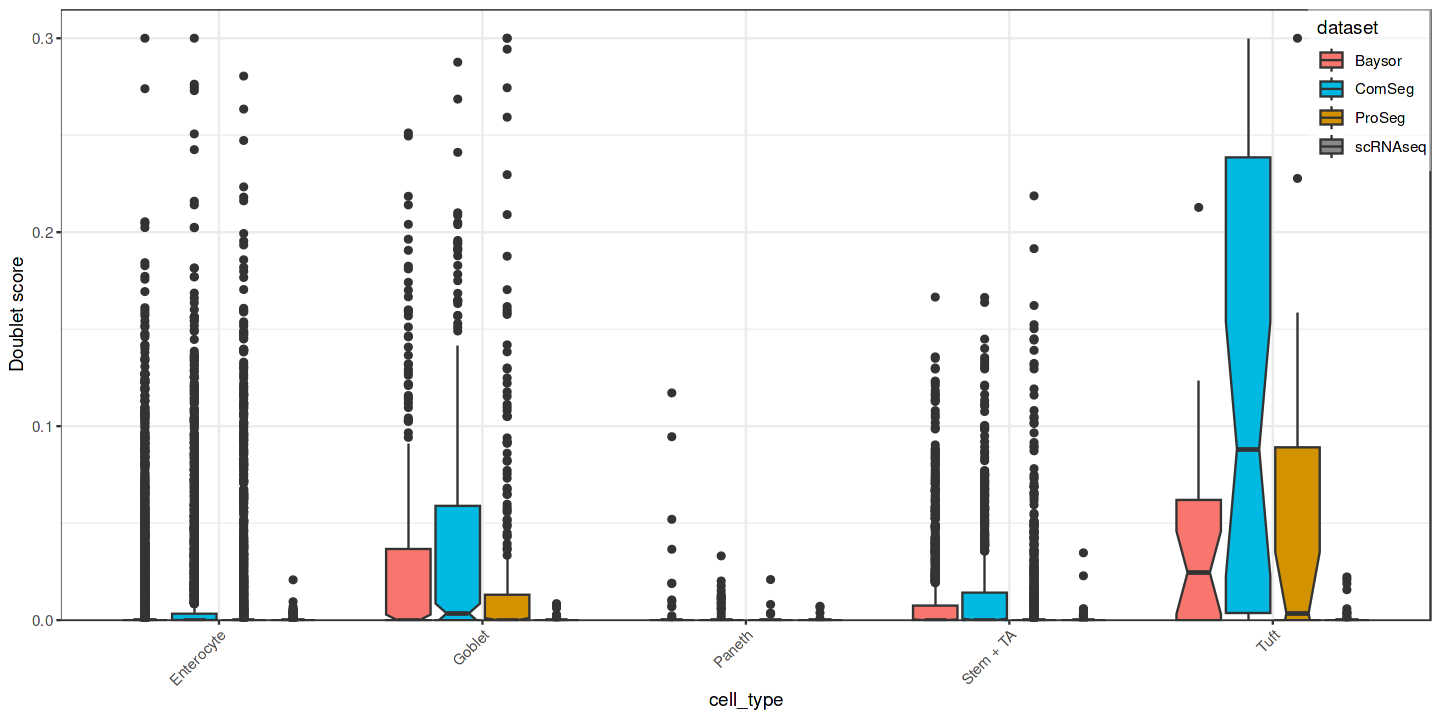

In [43]:
options(repr.plot.width=12, repr.plot.height=6)

ggplot(admix_score_df) +
  geom_boxplot(aes(x=cell_type, y=scores, fill=dataset), notch=TRUE) +
  scale_y_continuous(limits=c(0.0, 0.3), expand=c(0, 0, 0.05, 0)) +
  scale_fill_manual(values=palette) +
  ylab('Doublet score') + theme_legend(position=c(1, 1)) +
  theme(axis.text.x=element_text(angle=45, vjust=1, hjust=1))

## Compute scores on cleaned data

**WARNING:** here you need to run [GUT_per_seg_corrections.R](./GUT_per_seg_corrections.R) first.

In [177]:
## computing scores for the corrected datasets as well
# loadings the cleaned data as well
base_dir <- CachePath('gut_scaled_dat6/')
k <- 20
methods_test <- c('ComSeg', 'ProSeg','Baysor')
all_df_cln <- lapply(methods_test,function(method) {
    df_cln <- readRDS(file=paste0(base_dir,'df_k',k,'_cln_',method,'.rds'))
    df_cln <- df_cln[df_cln$celltype %in% common_cell_types,]
    return(df_cln)
})
shared_genes2 <- sapply(all_df_cln, function(x) return(x$gene)) %>% Reduce(intersect, .)
shared_genes_all <- intersect(shared_genes,shared_genes2)
names(all_df_cln) <- paste0(methods_test,'_cln')

all_so_cln <- lapply(1:length(all_df_cln),function(df_cln_ndx) {
    df_cln <- all_df_cln[[df_cln_ndx]]
    method <- names(all_df_cln)[df_cln_ndx]
    # make counts
    ctcln <- df_cln %$% table(gene, cell) %>% unclass() %>% as('dgCMatrix')
    ctcln <- ctcln[shared_genes_all,]
    # make cell metadata
    metacln <- unique(df_cln[,c('cell','celltype')])
    colnames(metacln)[2] <- 'cell_type'
    rownames(metacln) <- metacln$cell
    so <- CreateSeuratObject(ctcln,meta.data=metacln)
    so$sample <- method
    so <- process_seurat(so)
    return(so)
})
names(all_so_cln) <- paste0(methods_test,'_cln')

Centering and scaling data matrix

PC_ 1 
Positive:  Slc12a2, Stmn1, Mki67, Sox4, Kit, Cps1, Hmgb2, Adra2a, Lgr5, Smo 
	   Txndc5, Cd44, Clca3b, Htr4, Klk1, Krt7, Maged2, Cd14, Ffar2, Ffar4 
	   Fzd6, Mptx2, Chrm1, Tm4sf4, Jaml, Fzd2, Fzd9, Ptgdr2, Chrm3, Itgam 
Negative:  Slc51a, Apob, Slc5a1, Adgrd1, Lpar3, Maoa, Htr2c, Hrh1, Chrm4, Sdc1 
	   Ada, Ltb4r2, Lpar1, Tnfrsf21, Plb1, Cadm1, Glp1r, Ltb4r1, Ifng, Taar8c 
	   H2-Eb1, Acta2, Ptger4, Slc2a2, Scn3a, Cd8a, Nt5e, Ptger3, Mpo, Ms4a1 
PC_ 2 
Positive:  Nlrp6, Sdc1, Clca3b, Cps1, Maoa, Slc5a1, Fzd5, Itgam, H2-Eb1, Mki67 
	   Stmn1, Ifnar1, Slc51a, Net1, Hmgb2, Lpar1, Cd14, Cd44, Sox4, Apob 
	   Cckar, Htr4, Ccnl2, Smo, Fzd6, Fzd3, Lpar5, Lamp3, Fzd1, Acta2 
Negative:  Tm4sf4, Klk1, Ffar2, Kit, Chrm1, Tspan13, Mptx2, Slc18a1, Chrm3, Txndc5 
	   Tnfrsf21, Fzd9, Ccl9, Ptgdr2, Maged2, Ptgdr, Taar1, Slc12a2, Ptger4, Tpsb2 
	   Ada, Nt5e, Lrmp, Adrb2, Gp2, Gpr34, Gpr174, Gzmb, Sstr3, Thy1 
PC_ 3 
Positive:  Tnfrsf21, Tspan13, Ptger4, Marck

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3445
Number of edges: 166187

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.6284
Number of communities: 14
Elapsed time: 0 seconds


Centering and scaling data matrix

PC_ 1 
Positive:  Slc12a2, Stmn1, Mki67, Txndc5, Sox4, Cps1, Adra2a, Kit, Hmgb2, Cd44 
	   Clca3b, Lgr5, Smo, Htr4, Mptx2, Ffar2, Tm4sf4, Maged2, Chrm1, Krt7 
	   Cd14, Klk1, Jaml, Ptgdr2, Ffar4, Fzd9, Chrm3, Fzd6, Fzd2, Rcor2 
Negative:  Slc51a, Slc5a1, Apob, Maoa, Sdc1, Adgrd1, Lpar3, Hrh1, H2-Eb1, Htr2c 
	   Lpar1, Chrm4, Ada, Ltb4r2, Tnfrsf21, Acta2, Cadm1, Ltb4r1, Glp1r, Plb1 
	   Ifng, Ptger4, Taar8c, Scn3a, Slc2a2, Tbxa2r, Etv1, Cd8a, Ptger3, Nt5e 
PC_ 2 
Positive:  Tm4sf4, Tspan13, Tnfrsf21, Kit, Ffar2, Klk1, Chrm1, Slc18a1, Chrm3, Ptger4 
	   Mptx2, Fzd9, Maged2, Txndc5, Ccl9, Lpar3, Ada, Marcksl1, Ptgdr2, Neat1 
	   Taar7a, Krt7, Chrm4, Adgrd1, Lrmp, Hrh1, Sstr5, Vim, Adra2a, Plb1 
Negative:  Nlrp6, Clca3b, Cps1, Itgam, Mki67, Sdc1, Fzd5, Stmn1, Maoa, Cd44 
	   Hmgb2, Cd14, Htr4, Smo, Sox4, Net1, Cckar, H2-Eb1, Jaml, Slc5a1 
	   Lamp3, Lpar1, Fzd2, Fzd6, Fzd1, Slc51a, Fzd3, Ccnl2, Htr1b, Cmc1 
PC_ 3 
Positive:  Taar7a, Neat1, Cd44, H2-Eb1, L

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3975
Number of edges: 166309

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.6585
Number of communities: 22
Elapsed time: 0 seconds


Centering and scaling data matrix

PC_ 1 
Positive:  Slc12a2, Stmn1, Mki67, Sox4, Cps1, Txndc5, Smo, Hmgb2, Lgr5, Clca3b 
	   Adra2a, Cd44, Htr4, Kit, Mptx2, Klk1, Cd14, Maged2, Ffar2, Jaml 
	   Fzd6, Tm4sf4, Ffar4, Ptgdr2, Fzd9, Fzd2, Rcor2, Chrm1, Krt7, Itgam 
Negative:  Slc51a, Slc5a1, Apob, Maoa, Adgrd1, Neat1, Hrh1, Lpar3, Htr2c, Ltb4r2 
	   Chrm4, Sdc1, Lpar1, Tnfrsf21, Acta2, Ada, Taar7a, Cadm1, H2-Eb1, Plb1 
	   Ltb4r1, Ptger4, Glp1r, Ifng, Scn3a, Taar8c, Ifnar1, Cd8a, Tbxa2r, Slc2a2 
PC_ 2 
Positive:  Tm4sf4, Kit, Tspan13, Klk1, Ffar2, Tnfrsf21, Chrm1, Slc18a1, Chrm3, Mptx2 
	   Fzd9, Ptger4, Neat1, Txndc5, Ccl9, Marcksl1, Lrmp, Lpar3, Maged2, Krt7 
	   Ada, Sstr3, Slc12a2, Ptgdr2, Adra2a, Gpbar1, Pax6, Chrm4, Gzmb, Sstr5 
Negative:  Nlrp6, Cps1, Clca3b, Mki67, Itgam, Sdc1, Fzd5, Maoa, Stmn1, Hmgb2 
	   Slc51a, Cd14, H2-Eb1, Htr4, Sox4, Cd44, Smo, Slc5a1, Lamp3, Fzd6 
	   Cckar, Fzd1, Net1, Htr1b, Lpar1, Fzd3, Lpar5, Cmc1, Fzd2, Apob 
PC_ 3 
Positive:  Net1, Ccnl2, H2-Eb1, Sdc

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4177
Number of edges: 195500

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.6450
Number of communities: 15
Elapsed time: 0 seconds


In [178]:
sos2 <- lapply(sos[valid_methods],function(so){
    cm <- so[['RNA']]$counts[shared_genes_all,]
    meta <- so@meta.data
    so <- CreateSeuratObject(cm,meta.data=meta)
    so <- process_seurat(so)
    return(so)
})

Centering and scaling data matrix

PC_ 1 
Positive:  Slc51a, Apob, Slc5a1, Maoa, Adgrd1, Lpar3, Hrh1, Htr2c, Chrm4, Sdc1 
	   Ltb4r2, Ada, Acta2, Tnfrsf21, Lpar1, Cadm1, Plb1, Ifng, Glp1r, Ltb4r1 
	   H2-Eb1, Ptger4, Scn3a, Taar8c, Slc2a2, Taar7a, Cd8a, Ifnar1, Ptger3, Nt5e 
Negative:  Slc12a2, Stmn1, Sox4, Mki67, Cps1, Mptx2, Kit, Lgr5, Txndc5, Adra2a 
	   Smo, Clca3b, Hmgb2, Cd44, Htr4, Fzd9, Maged2, Cd14, Jaml, Fzd6 
	   Ptgdr2, Fzd2, Krt7, Chrm1, Ffar2, Chrm3, Tm4sf4, Ffar4, Rcor2, Ccl9 
PC_ 2 
Positive:  Cps1, Nlrp6, Clca3b, Mki67, Itgam, Stmn1, Taar5, Taar2, Adrb3, S100b 
	   Chrm5, Adra1b, Taar9, Drd1, Htr2a, Ccr7, Htr1a, Cckbr, Sox10, Sctr 
	   Crp, Foxp3, Il4, Neurog3, Gpr84, Ly6g, Ntsr1, Il9, Htr1b, Clec9a 
Negative:  Neat1, Tnfrsf21, Tspan13, Ptger4, Net1, Taar7a, Marcksl1, Tm4sf4, Lpar3, Slc18a1 
	   Ccnl2, Ifnar1, Vim, Acta2, Hrh1, Klk1, Krt7, Adgrd1, Lpar1, Ffar2 
	   H2-Eb1, S1pr2, Chrm4, Lrmp, Ltb4r2, Chrm1, Ada, Chrm3, Pax6, Kit 
PC_ 3 
Positive:  Nlrp6, Fzd5, Itgam, C

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4278
Number of edges: 203769

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.6248
Number of communities: 17
Elapsed time: 0 seconds


Centering and scaling data matrix

PC_ 1 
Positive:  Slc51a, Apob, Slc5a1, Lpar3, Adgrd1, Htr2c, Hrh1, Ada, Chrm4, Maoa 
	   Tnfrsf21, Ltb4r2, Plb1, Lpar1, Cadm1, Glp1r, Ifng, Ptger4, Sdc1, Ltb4r1 
	   Taar8c, Slc2a2, Acta2, Scn3a, Nt5e, Ptger3, H2-Eb1, Cd8a, Cd8b1, Ms4a1 
Negative:  Slc12a2, Stmn1, Cps1, Mki67, Sox4, Clca3b, Txndc5, Kit, Hmgb2, Adra2a 
	   Smo, Lgr5, Cd44, Mptx2, Htr4, Cd14, Krt7, Fzd6, Maged2, Jaml 
	   Fzd2, Ffar4, Itgam, Chrm1, Ffar2, Fzd9, Nlrp6, Ptgdr2, Rcor2, Lamp3 
PC_ 2 
Positive:  Mptx2, Cps1, Mki67, Stmn1, Clca3b, Lgr5, Neurog3, S100b, Taar2, Adrb3 
	   Adra1b, Foxp3, Taar9, Cckbr, Sox4, Htr2a, Nlrp6, Ccr7, Sctr, Thy1 
	   Sox10, Htr1a, Fzd9, Chrm5, Taar5, Drd1, Slc12a2, Ptgir, Gpr84, Gpr174 
Negative:  Ifnar1, H2-Eb1, Ptger4, Apob, Tnfrsf21, Tspan13, Sdc1, Marcksl1, Lpar1, Acta2 
	   Taar7a, Hrh1, Slc5a1, Ltb4r2, Maoa, Adgrd1, Chrm4, Lpar3, Ccnl2, Slc51a 
	   Net1, Neat1, S1pr2, Htr2c, Cadm1, Vim, Slc18a1, Fzd7, Tm4sf4, Fzd5 
PC_ 3 
Positive:  Nlrp6, Itgam,

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3447
Number of edges: 162370

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.6058
Number of communities: 17
Elapsed time: 0 seconds


Centering and scaling data matrix

PC_ 1 
Positive:  Slc51a, Apob, Slc5a1, Maoa, Sdc1, Adgrd1, Lpar3, Hrh1, H2-Eb1, Htr2c 
	   Chrm4, Lpar1, Ada, Ltb4r2, Tnfrsf21, Acta2, Cadm1, Glp1r, Ltb4r1, Plb1 
	   Ptger4, Ifng, Taar8c, Scn3a, Slc2a2, Tbxa2r, Etv1, Cd8a, Ptger3, Nt5e 
Negative:  Slc12a2, Stmn1, Mki67, Txndc5, Sox4, Cps1, Adra2a, Kit, Cd44, Clca3b 
	   Hmgb2, Lgr5, Mptx2, Smo, Htr4, Ffar2, Maged2, Chrm1, Tm4sf4, Cd14 
	   Krt7, Jaml, Ptgdr2, Fzd9, Ffar4, Klk1, Fzd6, Chrm3, Fzd2, Rcor2 
PC_ 2 
Positive:  Tm4sf4, Tspan13, Tnfrsf21, Kit, Ffar2, Klk1, Chrm1, Slc18a1, Chrm3, Ptger4 
	   Fzd9, Maged2, Mptx2, Txndc5, Ccl9, Marcksl1, Lpar3, Ada, Ptgdr2, Taar7a 
	   Neat1, Krt7, Chrm4, Adgrd1, Lrmp, Adra2a, Sstr5, Hrh1, Vim, Plb1 
Negative:  Nlrp6, Clca3b, Cps1, Itgam, Mki67, Sdc1, Fzd5, Maoa, Stmn1, Hmgb2 
	   Cd44, Cd14, Htr4, Smo, Sox4, Slc5a1, Net1, Cckar, H2-Eb1, Lamp3 
	   Jaml, Lpar1, Fzd2, Fzd6, Fzd1, Fzd3, Ccnl2, Htr1b, Cmc1, Cysltr2 
PC_ 3 
Positive:  Neat1, Taar7a, Cd44, H2-Eb1, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3977
Number of edges: 166992

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.6523
Number of communities: 23
Elapsed time: 0 seconds


In [179]:
sos3 <- c(sos2,all_so_cln)

In [180]:
sos3$scRNAseq <- so_rna

In [181]:
sos3 %<>% lapply(\(so) subset(so, cells=colnames(so)[so$cell_type %in% unique(common_cell_types)]))

In [182]:
names(sos3)

[1] "Baysor"     "ComSeg"     "ProSeg"     "ComSeg_cln" "ProSeg_cln"
[6] "Baysor_cln" "scRNAseq"

In [231]:
cont_infos <- lapply(sos3, \(so) {
  estimate_contamination_scores_seurat(
      sos$scRNAseq, so, cell.type.adj.mat=cell_type_adj_mat,
      p.c=0.25, signal.thres=0.25, min.expr.frac=0.05,max.prob.high=0.01,
      exclude.genes=exclude_genes, adjust=TRUE
  )
})

Warning message in estimate_contamination_scores(cm.rna = so.rna[["RNA"]]$counts, :
“Some genes not found in both cm.rna and cm.spatial, 232 genes left”
Warning message in FUN(X[[i]], ...):
“Genes with high expression in Enterocyte detected in contamination: 'Mptx2', 'Klk1', 'Mki67', 'Txndc5', 'Tspan13', 'Slc12a2'. Perhaps you should improve the annotation or mask these genes out (`exclude.genes`).”
Warning message in FUN(X[[i]], ...):
“Genes with high expression in Goblet detected in contamination: 'Fzd5', 'Cd44', 'Marcksl1', 'Slc5a1', 'Nlrp6', 'Net1', 'Sox4', 'Sdc1', 'Slc51a', 'Ifnar1'. Perhaps you should improve the annotation or mask these genes out (`exclude.genes`).”
Warning message in FUN(X[[i]], ...):
“Genes with high expression in Paneth detected in contamination: 'Cd44', 'Maoa', 'Slc5a1', 'Mki67', 'Lgr5', 'Cmc1', 'Sox4', 'Ffar4'. Perhaps you should improve the annotation or mask these genes out (`exclude.genes`).”
Warning message in FUN(X[[i]], ...):
“Genes with high expressi

In [245]:

admix_score_df <- names(cont_infos) %>% lapply(\(tn) {
    cont_infos[[tn]]$doublet.scores %>%
        {data.frame(scores=., cell_type=sos3[[tn]]$cell_type[names(.)], cell=names(.), dataset=tn)}
}) %>% bind_rows()

In [246]:
head(admix_score_df)

,scores,cell_type,cell,dataset
,<dbl>,<chr>,<chr>,<chr>
Baysor_C212,0.000000000,Enterocyte,Baysor_C212,Baysor
Baysor_C298,0.016739539,Enterocyte,Baysor_C298,Baysor
Baysor_C336,0.006749069,Enterocyte,Baysor_C336,Baysor
Baysor_C341,0.002172388,Enterocyte,Baysor_C341,Baysor
Baysor_C349,0.028144292,Enterocyte,Baysor_C349,Baysor
Baysor_C351,0.000000000,Enterocyte,Baysor_C351,Baysor


In [249]:
plot_ct_av_norm_scores_seg <- function(ref_dataset,scores_final_df,seg_unique,
                                       trim_level=NULL,min_mean_thresh=1e-3,
                                       y_max=NULL) {

    ## selecting the same cells from orig vs cln for each segmentation
    scores_final_df$cell2 <- sapply(scores_final_df$cell,function(x){
      tmp <- strsplit(x,split='_')[[1]][[2]]
      if (substr(tmp,1,1)!='C') {
        tmp <- paste0('C',tmp)
      }
      return(tmp)
    })

    scores_final_df2 <- list()
    for (seg in seg_unique) {
        if (strsplit(ref_dataset,split=' ')[[1]][[1]]==seg) {
            scores_sub1 <- scores_final_df[scores_final_df$dataset==ref_dataset,]
        } else {
            scores_sub1 <- scores_final_df[scores_final_df$dataset==seg,]
        }
      scores_sub2 <- scores_final_df[scores_final_df$dataset==paste0(seg,'_cln'),]

      cells_int <- intersect(scores_sub1$cell2,scores_sub2$cell2)
      scores_sub1 <- scores_sub1[scores_sub1$cell2 %in% cells_int,]
      scores_sub2 <- scores_sub2[scores_sub2$cell2 %in% cells_int,]
      scores_seg <- rbind.data.frame(scores_sub1,scores_sub2)
      scores_final_df2[[seg]] <- scores_seg
    }

    scores_final_df2[['scRNAseq']] <- scores_final_df[scores_final_df$dataset=='scRNAseq',]
    scores_final_df <- do.call(rbind.data.frame,scores_final_df2)

  if (!is.null(trim_level)) {
    # now computing trimmed average scores per cell type
    doublet_df_agg <- scores_final_df %>%
      group_by(dataset, cell_type) %>%
      summarise(scores = mean(scores, trim=trim_level, na.rm = TRUE))
  } else {
    doublet_df_agg <- scores_final_df %>%
      group_by(dataset, cell_type) %>%
      summarise(scores = mean(scores, na.rm = TRUE))
  }

  meta <- unique(scores_final_df[,c('dataset','method','cln_status','cell_type')])
  rownames(meta) <- paste0(meta$dataset,'_',meta$cell_type)
  meta <- meta[,c(2,3)]

  doublet_df_agg <- as.data.frame(doublet_df_agg)
  rownames(doublet_df_agg) <- paste0(doublet_df_agg$dataset,'_',doublet_df_agg$cell_type)
  doublet_df_agg <- cbind.data.frame(doublet_df_agg,meta[rownames(doublet_df_agg),])

  norm_scores <- doublet_df_agg %>% filter(dataset==ref_dataset) %$% setNames(scores, cell_type)
  doublet_df_agg <- doublet_df_agg %>%
    filter(norm_scores[cell_type] > min_mean_thresh) %>%
    mutate(scores = scores / norm_scores[cell_type])

  y_min <- 0
  if (is.null(y_max)) {
      y_max <- max(doublet_df_agg$scores)
      print(y_max)
  }

  p <- ggplot(doublet_df_agg) +
    geom_boxplot(aes(x=cln_status, y=scores),position = position_dodge(), outliers=FALSE) +
    geom_point(aes(x=cln_status, y=scores, color=cell_type),position = position_jitterdodge(jitter.width = 0.1,   # jitter within each dodge-group
                                                                                                         dodge.width = 0.8)) +
    facet_wrap(. ~ method,scales = "free_x",nrow = 1,strip.position = "bottom") +
    coord_cartesian(ylim = c(y_min,y_max)) +
    theme_legend(position=c(1, 1)) +
    geom_hline(yintercept=1,color='red',linetype='dashed') +
    guides(color=guide_legend("Cell type",keywidth=0.1,
                              keyheight=0.15,
                              default.unit="inch")) +
    scale_fill_manual(values = c("gray98","gray80",'black')) +
    xlab('') +
    ylab('Mean P_admix method/ref') +
    theme_bw() +
    theme(
        panel.spacing = unit(0, "lines"),         # removes spacing between panels
        # strip.background = element_blank(),       # removes strip background color
        panel.border = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1),
        strip.placement = "outside"
    )

  return(p)
}

In [250]:
admix_score_df$dataset <- factor(admix_score_df$dataset,levels=c('Baysor','ComSeg','ProSeg','ComSeg_cln','ProSeg_cln','Baysor_cln','scRNAseq'))
levels(admix_score_df$dataset) <- c('Baysor (ref)','ComSeg','ProSeg','ComSeg_cln','ProSeg_cln','Baysor_cln','scRNAseq')
admix_score_df$method <- sapply(admix_score_df$dataset,function(x){
    if (x %in% c('Baysor (ref)','Baysor_cln')) {
        return('Baysor (ref)')
    } else if (x %in% c('ComSeg','ComSeg_cln')) {
        return('ComSeg')
    } else if (x %in% c('ProSeg','ProSeg_cln')) {
        return('ProSeg')
    } else if (x=='scRNAseq') {
        return('scRNAseq')
    }
})
admix_score_df$cln_status <- sapply(admix_score_df$dataset,function(x){
    if (x %in% c('Baysor_cln','ComSeg_cln','ProSeg_cln')) {
        return('cleaned')
    } else if (x=='scRNAseq') {
        return('scRNAseq')
    } else {
        return('unclean')
    }
})


In [251]:
admix_score_df$cln_status <- factor(admix_score_df$cln_status,levels=c('unclean','cleaned','scRNAseq'))

`summarise()` has grouped output by 'dataset'. You can override using the `.groups` argument.


[1] 4.085681


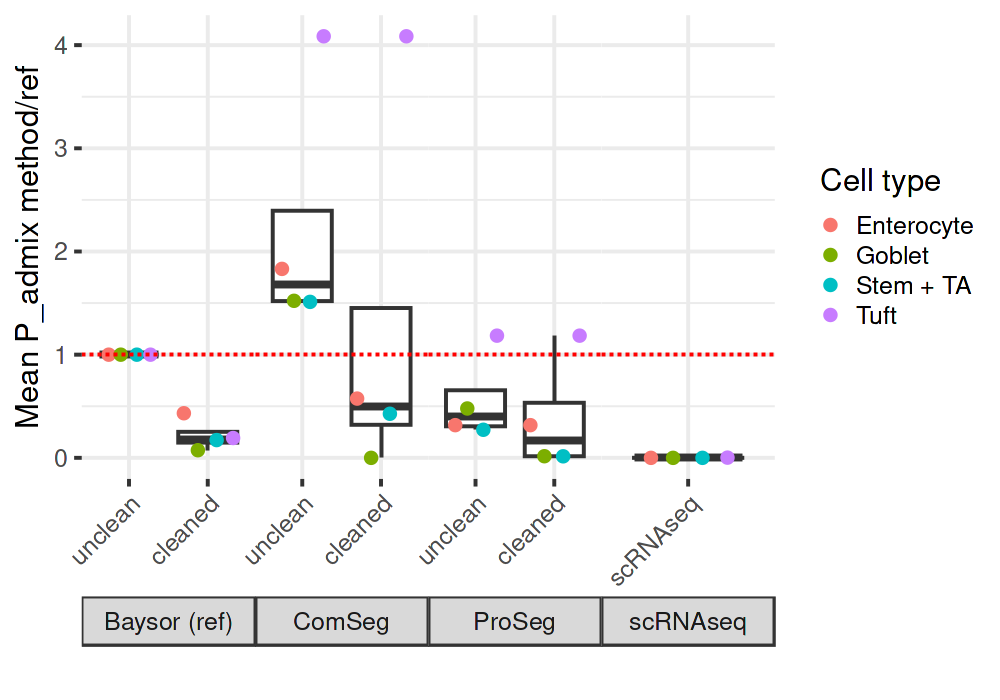

In [252]:
options(repr.plot.width = 5, repr.plot.height = 3.5, repr.plot.res = 200)

p1 <- plot_ct_av_norm_scores_seg(
  'Baysor (ref)',admix_score_df,
  seg_unique=c('Baysor','ComSeg','ProSeg'),
  trim_level=.1,min_mean_thresh=1e-3)
p1

In [253]:
p_final <- p1 + ggtitle('Mouse ileum dataset')  +
  theme(plot.title = element_text(hjust = 0.5), panel.spacing = unit(.75, "lines"))

In [254]:
pdf(OutputPath('gut_seg_compare.pdf'), useDingbats = FALSE, width = 6.5, height = 3.5)
p_final
dev.off()

png 
  2

In [208]:
### now for the reference, checking if there are differences by library size after conditioning on cell type

# getting lib sizes
so_spat <- sos[['Baysor']]
lib_size <- so_spat$nCount_RNA


0%  25%  50%  75% 100% 
  10   40   97  180  823

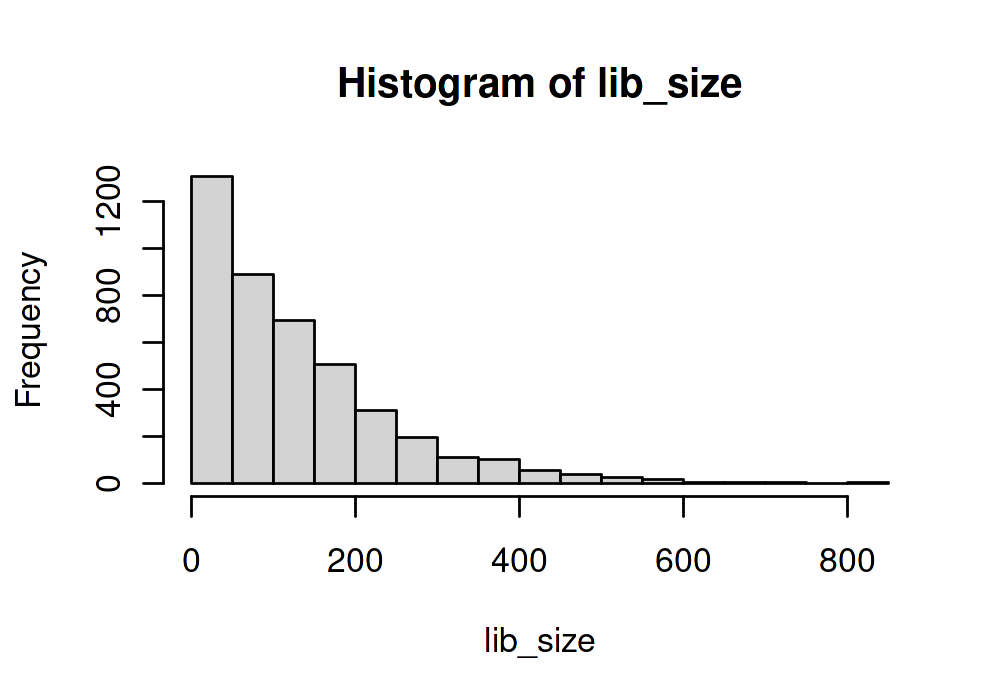

In [209]:
# looking at overall distribution
hist(lib_size)

# getting quantiles
quantile(lib_size)


In [216]:
scores_sub <- admix_score_df[admix_score_df$dataset=='Baysor (ref)',]

rownames(scores_sub) <- scores_sub$cell
scores_sub$lib_size <- lib_size[rownames(scores_sub)]

scores_sub <- scores_sub %>%
  group_by(cell_type) %>%
  mutate(lib_size_bin = ntile(lib_size, 4)) %>%  # 4 quantile bins
  ungroup()

In [217]:
head(scores_sub)

scores,cell_type,cell,dataset,method,cln_status,lib_size,lib_size_bin
<dbl>,<chr>,<chr>,<fct>,<chr>,<fct>,<dbl>,<int>
0.000000000,Enterocyte,Baysor_C212,Baysor (ref),Baysor (ref),unclean,60,2
0.016739539,Enterocyte,Baysor_C298,Baysor (ref),Baysor (ref),unclean,232,4
0.006749069,Enterocyte,Baysor_C336,Baysor (ref),Baysor (ref),unclean,12,1
0.002172388,Enterocyte,Baysor_C341,Baysor (ref),Baysor (ref),unclean,66,2
0.028144292,Enterocyte,Baysor_C349,Baysor (ref),Baysor (ref),unclean,55,2
0.000000000,Enterocyte,Baysor_C351,Baysor (ref),Baysor (ref),unclean,45,2


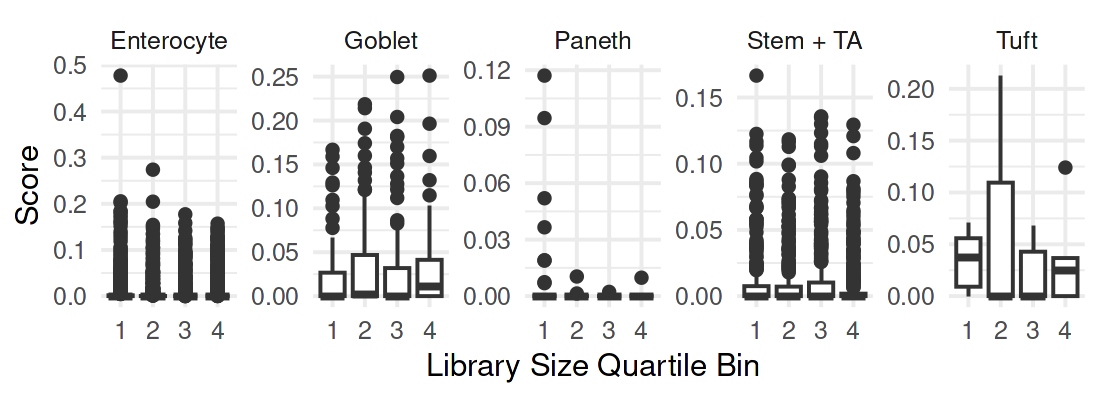

In [228]:
options(repr.plot.width = 5.5, repr.plot.height = 2, repr.plot.res = 200)

pq <- ggplot(scores_sub, aes(x = factor(lib_size_bin), y = scores)) +
  geom_boxplot() +
  facet_wrap(~ cell_type, scales = "free_y",nrow=1) +
  xlab("Library Size Quartile Bin") +
  ylab("Score") +
  theme_minimal()
pq

In [230]:
pdf(OutputPath('gut_lib_size_compare.pdf'), useDingbats = FALSE, width = 6.5, height = 2.5)
pq
dev.off()

png 
  2

In [221]:
scores_sub <- scores_sub %>%
  mutate(
    lib_size_bin = as.numeric(lib_size_bin),  # keep numeric to test linear trend
    cell_type = factor(cell_type)             # factor to stratify
  )

# Fit model with cell_type as a covariate
model <- lm(scores ~ lib_size_bin + cell_type, data = scores_sub)

# Summary of the model
summary(model)


Call:
lm(formula = scores ~ lib_size_bin + cell_type, data = scores_sub)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.03943 -0.01000 -0.00985 -0.00250  0.46805 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         9.709e-03  1.161e-03   8.361  < 2e-16 ***
lib_size_bin        7.242e-05  4.028e-04   0.180  0.85732    
cell_typeGoblet     1.799e-02  1.576e-03  11.419  < 2e-16 ***
cell_typePaneth    -7.552e-03  2.393e-03  -3.156  0.00161 ** 
cell_typeStem + TA  9.171e-04  1.061e-03   0.864  0.38754    
cell_typeTuft       2.943e-02  6.455e-03   4.559 5.27e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02946 on 4272 degrees of freedom
Multiple R-squared:  0.03772,	Adjusted R-squared:  0.03659 
F-statistic: 33.49 on 5 and 4272 DF,  p-value: < 2.2e-16
